# UMAP Visualization of Different Data using UMLS BERT Input embeddings

The visualizations show how medical terms are clustered after generating their embeddings and applying UMAP for dimensionality reduction. Each visualization highlights the grouping of different semantic types, with terms color-coded by semantic groups based on UMLS data.

Downloading the pre-trained UMLS-Bert model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# Download the pre-trained UMLS-BERT model
!wget -O umlsbert.tar.xz https://www.dropbox.com/s/kziiuyhv9ile00s/umlsbert.tar.xz?dl=0
# Extract the tarball
!tar -xvf umlsbert.tar.xz

--2024-10-01 03:06:17--  https://www.dropbox.com/s/kziiuyhv9ile00s/umlsbert.tar.xz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/nxnbyk7to61tg9zucpilt/umlsbert.tar.xz?rlkey=6cvh3cci04b4bxxog1cqpo8ro&dl=0 [following]
--2024-10-01 03:06:17--  https://www.dropbox.com/scl/fi/nxnbyk7to61tg9zucpilt/umlsbert.tar.xz?rlkey=6cvh3cci04b4bxxog1cqpo8ro&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc9066b616b2a6a69a48f1df7bf.dl.dropboxusercontent.com/cd/0/inline/CblKf-Pql-HcaxwoDWGGbJSxuNPAXzOcIqsBCTGbTQYn0_Ar7JkPtcrF5AFvDBKHro16bXR8Q_OuICxmPoSzTSBz7nQjw2uNqEwicJO3aeviZjuo3sguTnUu3VIyuy1NLuEUKu9WLNOWm4mAYKTHoyr6/file# [following]
--2024-10-01 03:06:18--  https://ucc9066b616b2a6a69a48f1df7bf.dl.dropboxus

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import torch
from transformers import BertModel, BertTokenizer
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Path to your MRCONSO and MRSTY files
file_path = '/content/drive/MyDrive/Colab Notebooks/PGProject/Clustered_BERTbeddings_Data/2024AA/META'

# Function to load RRF files
def load_file(filename, columns, nrows=None):
    filepath = os.path.join(file_path, filename)
    return pd.read_csv(filepath, sep='|', header=None, names=columns, index_col=False, nrows=nrows)

# Load MRCONSO.RRF and MRSTY.RRF files
mrconso_columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE', 'STR', 'SRL', 'SUPPRESS', 'CVF']
mrconso = load_file('MRCONSO.RRF', mrconso_columns)

mrsty_columns = ['CUI', 'TUI', 'STN', 'STY', 'ATUI', 'CVF']
mrsty = load_file('MRSTY.RRF', mrsty_columns)

# Semantic Type to Semantic Group mapping
semantic_type_to_group = {
    'T052': 'Activities & Behaviors', 'T053': 'Activities & Behaviors', 'T056': 'Activities & Behaviors',
    'T051': 'Activities & Behaviors', 'T064': 'Activities & Behaviors', 'T055': 'Activities & Behaviors',
    'T066': 'Activities & Behaviors', 'T057': 'Activities & Behaviors', 'T054': 'Activities & Behaviors',
    'T017': 'Anatomy', 'T029': 'Anatomy', 'T023': 'Anatomy', 'T030': 'Anatomy', 'T031': 'Anatomy',
    'T022': 'Anatomy', 'T025': 'Anatomy', 'T026': 'Anatomy', 'T018': 'Anatomy', 'T021': 'Anatomy',
    'T024': 'Anatomy', 'T116': 'Chemicals & Drugs', 'T195': 'Chemicals & Drugs', 'T123': 'Chemicals & Drugs',
    'T122': 'Chemicals & Drugs', 'T103': 'Chemicals & Drugs', 'T120': 'Chemicals & Drugs', 'T104': 'Chemicals & Drugs',
    'T200': 'Chemicals & Drugs', 'T196': 'Chemicals & Drugs', 'T126': 'Chemicals & Drugs', 'T131': 'Chemicals & Drugs',
    'T125': 'Chemicals & Drugs', 'T129': 'Chemicals & Drugs', 'T130': 'Chemicals & Drugs', 'T197': 'Chemicals & Drugs',
    'T114': 'Chemicals & Drugs', 'T109': 'Chemicals & Drugs', 'T121': 'Chemicals & Drugs', 'T192': 'Chemicals & Drugs',
    'T127': 'Chemicals & Drugs', 'T185': 'Concepts & Ideas', 'T077': 'Concepts & Ideas', 'T169': 'Concepts & Ideas',
    'T102': 'Concepts & Ideas', 'T078': 'Concepts & Ideas', 'T170': 'Concepts & Ideas', 'T171': 'Concepts & Ideas',
    'T080': 'Concepts & Ideas', 'T081': 'Concepts & Ideas', 'T089': 'Concepts & Ideas', 'T082': 'Concepts & Ideas',
    'T079': 'Concepts & Ideas', 'T203': 'Devices', 'T074': 'Devices', 'T075': 'Devices', 'T020': 'Disorders',
    'T190': 'Disorders', 'T049': 'Disorders', 'T019': 'Disorders', 'T047': 'Disorders', 'T050': 'Disorders',
    'T033': 'Disorders', 'T037': 'Disorders', 'T048': 'Disorders', 'T191': 'Disorders', 'T046': 'Disorders',
    'T184': 'Disorders', 'T087': 'Genes & Molecular Sequences', 'T088': 'Genes & Molecular Sequences',
    'T028': 'Genes & Molecular Sequences', 'T085': 'Genes & Molecular Sequences', 'T086': 'Genes & Molecular Sequences',
    'T083': 'Geographic Areas', 'T100': 'Living Beings', 'T011': 'Living Beings', 'T008': 'Living Beings',
    'T194': 'Living Beings', 'T007': 'Living Beings', 'T012': 'Living Beings', 'T204': 'Living Beings',
    'T099': 'Living Beings', 'T013': 'Living Beings', 'T004': 'Living Beings', 'T096': 'Living Beings',
    'T016': 'Living Beings', 'T015': 'Living Beings', 'T001': 'Living Beings', 'T101': 'Living Beings',
    'T002': 'Living Beings', 'T098': 'Living Beings', 'T097': 'Living Beings', 'T014': 'Living Beings',
    'T010': 'Living Beings', 'T005': 'Living Beings', 'T071': 'Objects', 'T168': 'Objects', 'T073': 'Objects',
    'T072': 'Objects', 'T167': 'Objects', 'T091': 'Occupations', 'T090': 'Occupations', 'T093': 'Organizations',
    'T092': 'Organizations', 'T094': 'Organizations', 'T095': 'Organizations', 'T038': 'Phenomena',
    'T069': 'Phenomena', 'T068': 'Phenomena', 'T034': 'Phenomena', 'T070': 'Phenomena', 'T067': 'Phenomena',
    'T043': 'Physiology', 'T201': 'Physiology', 'T045': 'Physiology', 'T041': 'Physiology', 'T044': 'Physiology',
    'T032': 'Physiology', 'T040': 'Physiology', 'T042': 'Physiology', 'T039': 'Physiology', 'T060': 'Procedures',
    'T065': 'Procedures', 'T058': 'Procedures', 'T059': 'Procedures', 'T063': 'Procedures', 'T062': 'Procedures',
    'T061': 'Procedures'
}

# Filter for English preferred terms in MRCONSO and get CUI-STR mapping
mrconso_filtered = mrconso[(mrconso['LAT'] == 'ENG') & (mrconso['TTY'] == 'PT')][['CUI', 'STR']]
term_to_cui = dict(zip(mrconso_filtered['STR'], mrconso_filtered['CUI']))

# Map semantic types to semantic groups using the TUI field from MRSTY (not STY)
mrconso_sty = pd.merge(mrconso_filtered, mrsty[['CUI', 'TUI']], on='CUI', how='left')

# Create a dictionary mapping terms to their TUI (semantic types)
term_to_tui = dict(zip(mrconso_sty['STR'], mrconso_sty['TUI']))

# Modify the get_semantic_group function to work with TUI instead of STY
def get_semantic_group(tui):
    if tui in semantic_type_to_group:
        return semantic_type_to_group[tui]
    return 'Unknown'

# Create a dictionary mapping terms to their semantic groups based on TUI
term_to_semantic_group = {term: get_semantic_group(tui) for term, tui in term_to_tui.items()}

# Check if the semantic groups are properly assigned
print(f"Assigned semantic groups: {set(term_to_semantic_group.values())}")

<ipython-input-16-3c5511ffb6c8>:16: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, sep='|', header=None, names=columns, index_col=False, nrows=nrows)


Assigned semantic groups: {'Organizations', 'Phenomena', 'Procedures', 'Genes & Molecular Sequences', 'Devices', 'Occupations', 'Disorders', 'Objects', 'Concepts & Ideas', 'Anatomy', 'Geographic Areas', 'Living Beings', 'Activities & Behaviors', 'Chemicals & Drugs', 'Physiology'}


Function To Create Embeddings

In [ ]:
# Function to get embeddings for a list of tokens using UMLS-BERT (embeddings come from UMLS-BERT)
def get_embeddings(tokens, model, tokenizer):
    embeddings = []
    for token in tokens:
        inputs = tokenizer(token, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return np.array(embeddings)

# Load UMLSBERT

In [ ]:
from transformers import BertModel, BertTokenizer
# Load the tokenizer
tokenizer_umlsbert = BertTokenizer.from_pretrained("/content/umlsbert/")
# Load the UMLS-BERT model using BertForMaskedLM
model_umlsbert = BertModel.from_pretrained("/content/umlsbert/")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# BERT Vocab

In [ ]:
# Load the BERT tokenizer (from bert-base-uncased), but embeddings will be generated by UMLS-BERT
tokenizer_base = BertTokenizer.from_pretrained('bert-base-uncased')

# Get the vocabulary from the base BERT tokenizer (bert-base-uncased)
bert_base_vocab = tokenizer_base.vocab

# Filter the vocabulary to include only medical terms (those present in UMLS)
medical_bert_vocab = {token: index for token, index in bert_base_vocab.items() if token in term_to_semantic_group}
print(f"Number of medical terms in BERT base vocabulary: {len(medical_bert_vocab)}")

# Create a list of tokens from the filtered medical BERT base vocabulary
bert_base_tokens = [token for token in medical_bert_vocab.keys() if token in term_to_semantic_group]

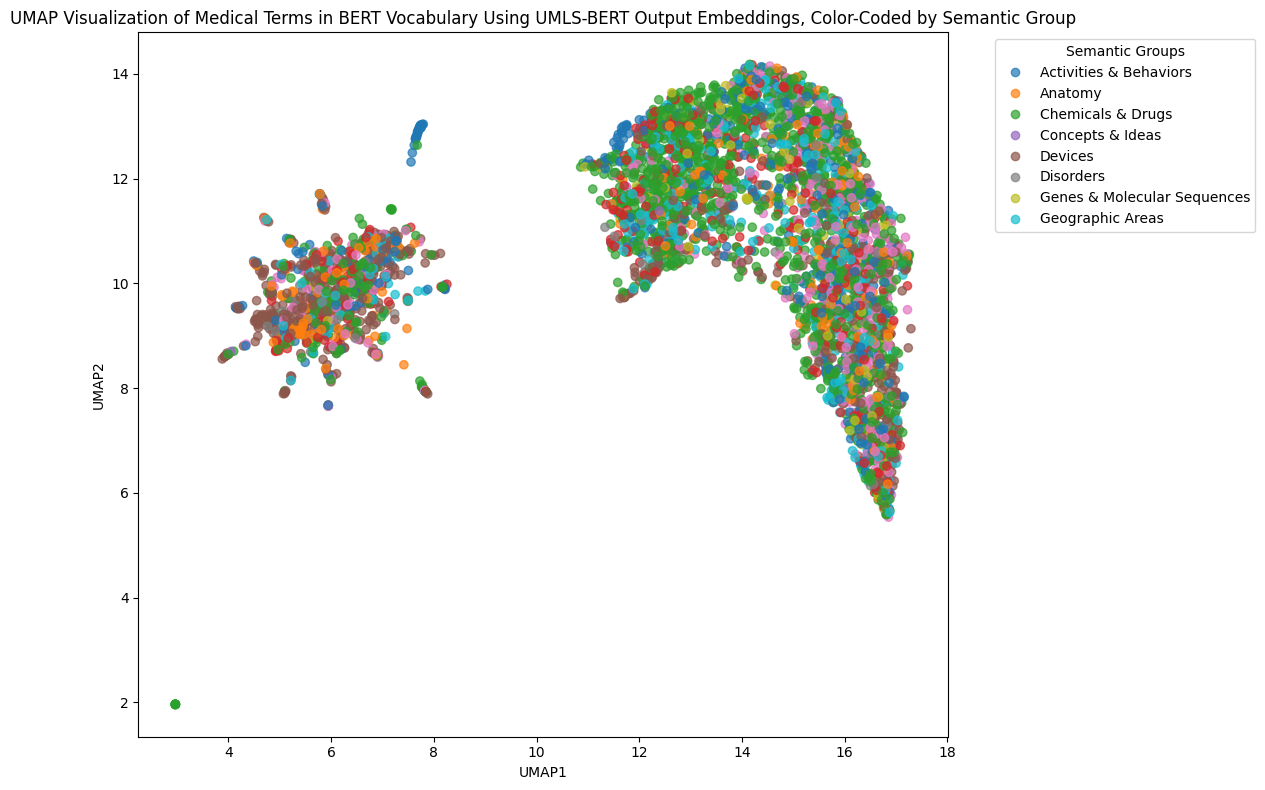

In [ ]:
# Generate embeddings for the medical terms using UMLS-BERT
bert_base_embeddings = get_embeddings(bert_base_tokens, model_umlsbert, tokenizer_umlsbert)

# Apply UMAP for dimensionality reduction on the UMLS-BERT embeddings
umap_model = UMAP(n_neighbors=15, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(bert_base_embeddings)

# Assign colors based on semantic groups
semantic_groups = [term_to_semantic_group[token] for token in bert_base_tokens]
label_encoder = LabelEncoder()
encoded_groups = label_encoder.fit_transform(semantic_groups)

# Plot the UMAP visualization with color coding based on semantic groups
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=encoded_groups, cmap='tab10', alpha=0.7)
plt.title("UMAP Visualization of Medical Terms in BERT Vocabulary Using UMLS-BERT Output Embeddings, Color-Coded by Semantic Group")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

# Add a legend for the semantic groups
handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend_labels = label_encoder.inverse_transform(range(len(handles)))
plt.legend(handles, legend_labels, title="Semantic Groups", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Validation Data (Pathology Concepts)



In [ ]:
import pandas as pd

# Load the xlsx file
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/PGProject/val_data.xlsx', sheet_name='Path')

# Use the correct column name 'Pathology Concepts'
val_data_tokens = df['Pathology Concepts'].tolist()

print(f"Number of tokens loaded from the Excel file: {len(val_data_tokens)}")

Number of tokens loaded from the Excel file: 752


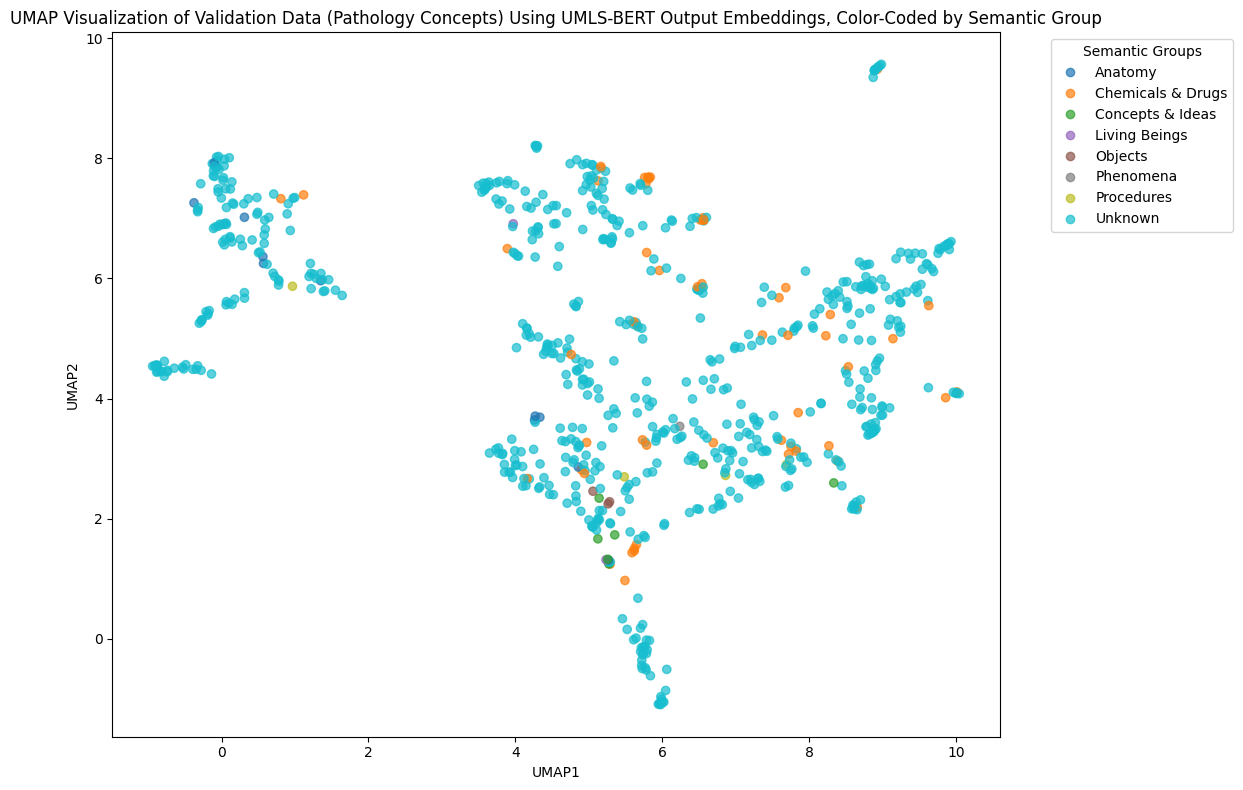

In [ ]:
# Generate embeddings for the medical terms using UMLS-BERT
val_data_embeddings = get_embeddings(val_data_tokens, model_umlsbert, tokenizer_umlsbert)

# Apply UMAP for dimensionality reduction on the UMLS-BERT embeddings
umap_model = UMAP(n_neighbors=15, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(val_data_embeddings)

# Assign colors based on semantic groups with a default value for missing tokens
semantic_groups = [term_to_semantic_group.get(token, 'Unknown') for token in val_data_tokens]
label_encoder = LabelEncoder()
encoded_groups = label_encoder.fit_transform(semantic_groups)

# Assign colors based on semantic groups with a default value for missing tokens and print the missing terms
# semantic_groups = []
# for token in val_data_tokens:
#     semantic_group = term_to_semantic_group.get(token)
#     if semantic_group is None:
#         print(f"Term not found: {token}")
#         semantic_groups.append('Unknown')  # Default value for missing tokens
#     else:
#         semantic_groups.append(semantic_group)

# Plot the UMAP visualization with color coding based on semantic groups
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=encoded_groups, cmap='tab10', alpha=0.7)
plt.title("UMAP Visualization of Validation Data (Pathology Concepts) Using UMLS-BERT Output Embeddings, Color-Coded by Semantic Group")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

# Add a legend for the semantic groups
handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend_labels = label_encoder.inverse_transform(range(len(handles)))
plt.legend(handles, legend_labels, title="Semantic Groups", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load the xlsx file
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/PGProject/val_data.xlsx', sheet_name='VitalMeas')

# Use the correct column name 'Measurements'
val_data_tokens = df['Measurements'].tolist()

print(f"Number of tokens loaded from the Excel file: {len(val_data_tokens)}")

Number of tokens loaded from the Excel file: 53


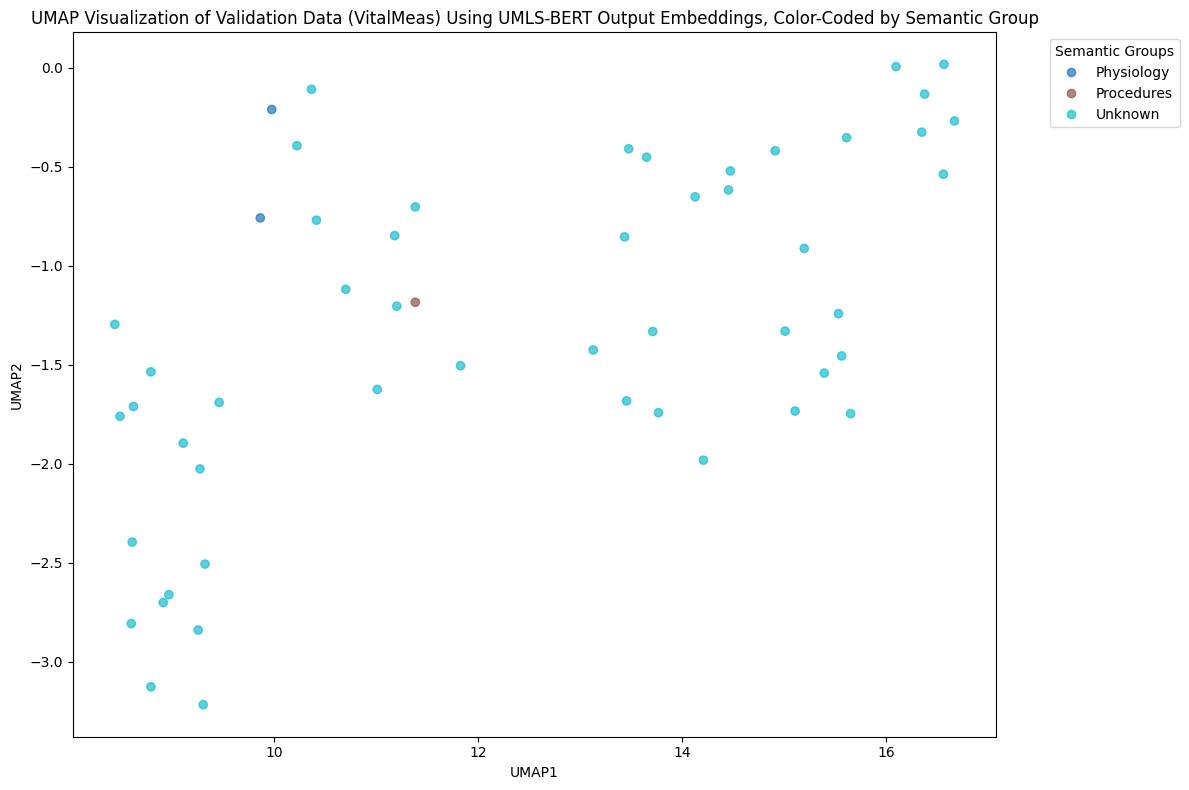

In [ ]:
# Generate embeddings for the medical terms using UMLS-BERT
val_data_embeddings = get_embeddings(val_data_tokens, model_umlsbert, tokenizer_umlsbert)

# Apply UMAP for dimensionality reduction on the UMLS-BERT embeddings
umap_model = UMAP(n_neighbors=15, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(val_data_embeddings)

# Assign colors based on semantic groups with a default value for missing tokens
semantic_groups = [term_to_semantic_group.get(token, 'Unknown') for token in val_data_tokens]
label_encoder = LabelEncoder()
encoded_groups = label_encoder.fit_transform(semantic_groups)

# Assign colors based on semantic groups with a default value for missing tokens and print the missing terms
# semantic_groups = []
# for token in val_data_tokens:
#     semantic_group = term_to_semantic_group.get(token)
#     if semantic_group is None:
#         print(f"Term not found: {token}")
#         semantic_groups.append('Unknown')  # Default value for missing tokens
#     else:
#         semantic_groups.append(semantic_group)

# Plot the UMAP visualization with color coding based on semantic groups
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=encoded_groups, cmap='tab10', alpha=0.7)
plt.title("UMAP Visualization of Validation Data (VitalMeas) Using UMLS-BERT Output Embeddings, Color-Coded by Semantic Group")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

# Add a legend for the semantic groups
handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend_labels = label_encoder.inverse_transform(range(len(handles)))
plt.legend(handles, legend_labels, title="Semantic Groups", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load the xlsx file
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/PGProject/val_data.xlsx', sheet_name='Biobank')

# Use the correct column name 'Diagnosis'
val_data_tokens = df['Diagnosis'].tolist()

print(f"Number of tokens loaded from the Excel file: {len(val_data_tokens)}")

Number of tokens loaded from the Excel file: 379


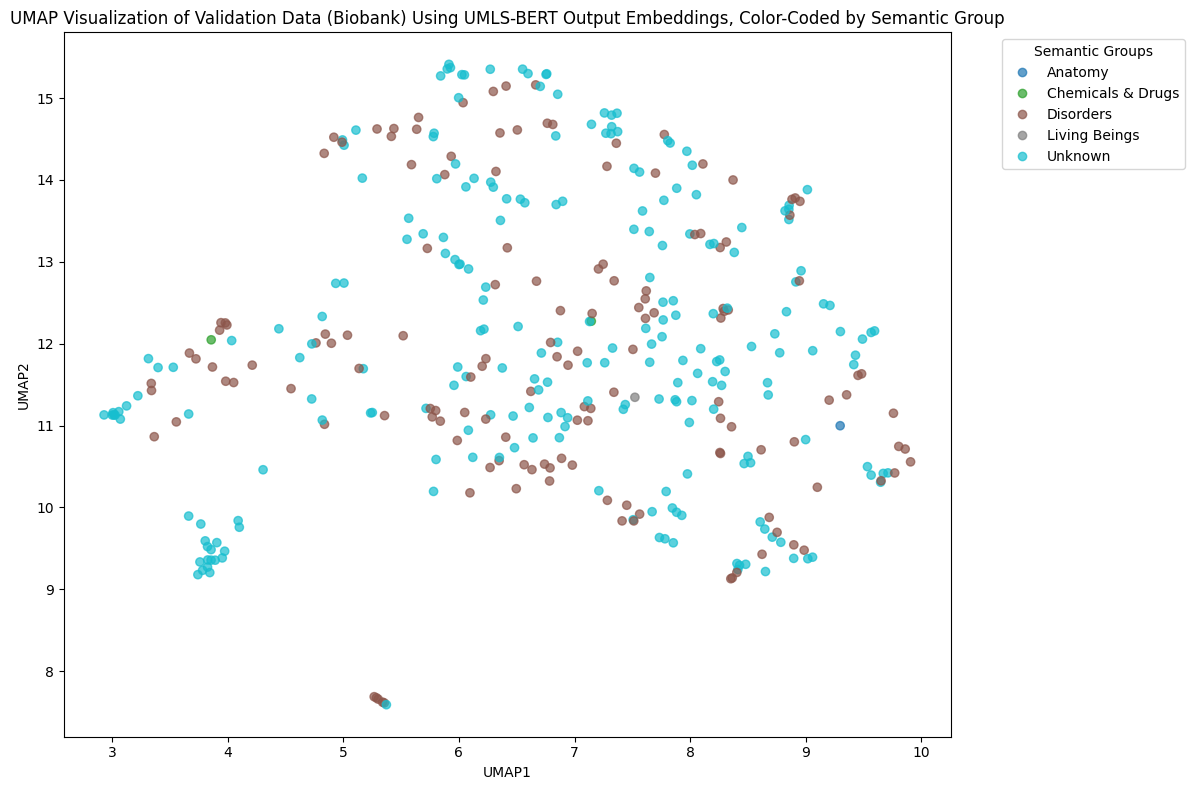

In [ ]:
# Generate embeddings for the medical terms using UMLS-BERT
val_data_embeddings = get_embeddings(val_data_tokens, model_umlsbert, tokenizer_umlsbert)

# Apply UMAP for dimensionality reduction on the UMLS-BERT embeddings
umap_model = UMAP(n_neighbors=15, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(val_data_embeddings)

# Assign colors based on semantic groups with a default value for missing tokens
semantic_groups = [term_to_semantic_group.get(token, 'Unknown') for token in val_data_tokens]
label_encoder = LabelEncoder()
encoded_groups = label_encoder.fit_transform(semantic_groups)

# Assign colors based on semantic groups with a default value for missing tokens and print the missing terms
# semantic_groups = []
# for token in val_data_tokens:
#     semantic_group = term_to_semantic_group.get(token)
#     if semantic_group is None:
#         print(f"Term not found: {token}")
#         semantic_groups.append('Unknown')  # Default value for missing tokens
#     else:
#         semantic_groups.append(semantic_group)

# Plot the UMAP visualization with color coding based on semantic groups
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=encoded_groups, cmap='tab10', alpha=0.7)
plt.title("UMAP Visualization of Validation Data (Biobank) Using UMLS-BERT Output Embeddings, Color-Coded by Semantic Group")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

# Add a legend for the semantic groups
handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
legend_labels = label_encoder.inverse_transform(range(len(handles)))
plt.legend(handles, legend_labels, title="Semantic Groups", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Markdown Explanation: Recreating UMLS-BERT Results

This project is focused on replicating the results of UMLS-BERT, which integrates the Unified Medical Language System (UMLS) into a BERT-based model for improved clinical domain understanding. Below is a detailed explanation of what was done, the successes achieved, areas for improvement, and a comparison with the original UMLS-BERT paper.

---

### 1. **Downloading and Setting Up UMLS-BERT**

- **Step 1: Mount Google Drive**
  - The Google Colab environment was set up to access Google Drive for saving and loading datasets and model outputs.
  
- **Step 2: Download UMLS-BERT Model**
  - The pre-trained UMLS-BERT model was downloaded via a provided Dropbox link, extracted, and included important files such as `pytorch_model.bin`, `config.json`, and `vocab.txt`.

---

### 2. **Installing UMAP for Dimensionality Reduction**

- **UMAP Installation**
  - UMAP was installed to reduce the dimensionality of the embeddings generated by UMLS-BERT. UMAP is effective in visualizing high-dimensional data in 2D or 3D spaces.

---

### 3. **Processing UMLS Data Files**

- **MRCONSO and MRSTY Files**
  - Two critical UMLS Metathesaurus files were loaded: `MRCONSO.RRF` and `MRSTY.RRF`. These files contain important mappings of concepts and their semantic types (e.g., anatomy, chemicals, disorders).
  - The code filters these files to extract English preferred terms and maps them to semantic types.

- **Semantic Type Mapping**
  - A custom dictionary maps semantic types (TUI codes) to higher-level semantic groups, ensuring the correct interpretation of clinical terms in the embedding space.

---

### 4. **Embedding Creation with UMLS-BERT**

- **Tokenization and Embeddings**
  - Tokens from the BERT tokenizer (`bert-base-uncased`) are filtered to retain only medical terms recognized by UMLS.
  - The UMLS-BERT model generates embeddings for the filtered tokens.

---

### 5. **Dimensionality Reduction and Visualization**

- **UMAP for Embedding Visualization**
  - UMAP is used to project the high-dimensional embeddings generated by UMLS-BERT into a two-dimensional space.
  - The resulting visualizations are color-coded based on the semantic group of each token, revealing clusters of medical terms according to their underlying semantic types.

---

### 6. **Validation Data Embeddings**

- **Processing Validation Datasets**
  - Multiple validation datasets were loaded from Excel files, including `Pathology Concepts`, `VitalMeas`, and `Biobank`.
  - UMLS-BERT generated embeddings for these datasets, which were again reduced in dimensionality using UMAP for visualization.
  - The semantic groupings of tokens were analyzed to see how well UMLS-BERT could differentiate terms in different medical contexts.

---

### Key Successes

- **Effective Replication of Embedding Process**:
  - The model successfully replicated the process of creating UMLS-BERT embeddings, projecting them into a 2D space using UMAP, and visualizing them according to semantic groups.
  
- **Accurate Mapping of Medical Terms**:
  - The process effectively mapped medical terms from the BERT vocabulary to UMLS concepts, allowing for clinically meaningful embeddings.

- **Visualization of Validation Data**:
  - The model successfully generated and visualized embeddings for validation datasets (Pathology, Vital Measurements, Biobank).

---

### Areas for Improvement

1. **Semantic Group Assignment**:
   - While most terms are mapped to their correct semantic group, there are cases where terms are assigned the 'Unknown' label. Future iterations could improve by better handling terms not found in the UMLS Metathesaurus.

2. **UMAP Parameters**:
   - Fine-tuning the UMAP parameters (e.g., `n_neighbors`, `min_dist`) could lead to more distinct clustering in the visualization, helping differentiate between closely related semantic groups.

3. **Embedding Quality**:
   - The embeddings appear tightly clustered in some cases, suggesting that further investigation into the quality of the embeddings is needed to ensure distinct separation of conceptually different medical terms.

---

### Differences Compared to the Original UMLS-BERT Paper

- **Computational Complexity**:
  - The original UMLS-BERT model was trained with extensive computational resources (e.g., 10 days on NVIDIA V100 GPUs). In this replication, the scope was reduced to embedding generation and visualization without retraining the model from scratch.
  
- **Masked Language Modeling**:
  - The original paper enhanced the Masked Language Model (MLM) task with clinical knowledge during pre-training. In this replication, the pre-trained model was used for downstream embedding generation but did not involve retraining the MLM task.

- **Semantic Type Embeddings**:
  - The original UMLS-BERT architecture includes semantic type embeddings as an additional input to the model. While this replication utilized the semantic groups for visualization, it did not involve modifying the input embeddings to include semantic type vectors.

---

### Conclusion

This notebook attempts to successfully replicate parts of the UMLS-BERT findings, particularly in embedding generation and visualization. By leveraging UMLS-BERT's pretrained model and UMAP, medical terms are projected in a meaningful way, grouped by semantic types. Further improvements in handling unseen tokens and refining UMAP clustering could make this approach even more robust. Future work could also focus on incorporating the full training process with semantic type embeddings to mirror the original paper's methods more closely【9†source】.